In [2]:
import torch
from torch import nn
from torch.nn import functional as F

# Tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
import numpy as np
tf.keras.backend.set_floatx('float64')

### Xây dựng lớp convolution

#### Convolution bằng numpy

In [4]:
def conv2d(X, K): 
    """Compute 2D convolution."""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # print(np.sum(X[i:i + h, j:j + w] * K))
            Y[i, j] = np.sum(X[i:i + h, j:j + w] * K)
    return Y

In [5]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

array([[19., 25.],
       [37., 43.]])

#### Convolution bằng tensorflow

In [6]:

K_tensor = K.reshape((2, 2, 1, 1))
X_tensor = X.reshape((1, 3, 3, 1))

conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 2), strides=(1, 1), padding='valid', use_bias=False)
conv_layer.build(input_shape=(None, 3, 3, 1))
conv_layer.set_weights([K_tensor])

# Apply the convolutional layer to the input tensor
output = conv_layer(X_tensor)

# Print the output of the convolutional layer
print(output)

tf.Tensor(
[[[[19.]
   [25.]]

  [[37.]
   [43.]]]], shape=(1, 2, 2, 1), dtype=float64)


### Hàm convolution đầy đủ

In [7]:

def conv2d(x, W, stride=1, padding=0):
    """
    Performs a 2D convolution on input tensor x with filter W.

    Args:
    x: Input tensor, shape [batch, in_height, in_width, in_channels]
    W: Filter tensor, shape [filter_height, filter_width, in_channels, out_channels]
    stride: Stride of the convolution in each dimension
    padding: Padding size to apply to the input tensor

    Returns:
    A tensor of shape [batch, out_height, out_width, out_channels] containing the result
    of the convolution.
    """

    batch, in_height, in_width, in_channels = x.shape
    filter_height, filter_width, _, out_channels = W.shape

    # Compute output dimensions
    out_height = int((in_height + 2*padding - filter_height) / stride + 1)
    out_width = int((in_width + 2*padding - filter_width) / stride + 1)

    # Add padding to input tensor
    x_padded = np.pad(x, [(0,0), (padding, padding), (padding, padding), (0,0)], mode='constant')

    # Initialize output tensor
    output = np.zeros((batch, out_height, out_width, out_channels))

    # Perform convolution
    for b in range(batch):
        for h in range(out_height):
            for w in range(out_width):
                for c in range(out_channels):
                    # Compute slice of input tensor to apply filter to
                    h_start = h * stride
                    h_end = h_start + filter_height
                    w_start = w * stride
                    w_end = w_start + filter_width
                    x_slice = x_padded[b, h_start:h_end, w_start:w_end, :]

                    # Apply filter to input slice
                    output[b, h, w, c] = np.sum(x_slice * W[:, :, :, c])

    return output

In [8]:
conv2d(X_tensor, K_tensor, stride=1, padding=1)

array([[[[ 0.],
         [ 3.],
         [ 8.],
         [ 4.]],

        [[ 9.],
         [19.],
         [25.],
         [10.]],

        [[21.],
         [37.],
         [43.],
         [16.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 0.]]]])

In [9]:
model = tf.keras.Sequential([
# tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 2), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.Constant(K_tensor))
])

# Apply the convolutional layer to the input tensor
output = model(X_tensor)

# Print the output of the convolutional layer
print(output)

tf.Tensor(
[[[[19.]
   [25.]
   [10.]]

  [[37.]
   [43.]
   [16.]]

  [[ 7.]
   [ 8.]
   [ 0.]]]], shape=(1, 3, 3, 1), dtype=float64)


#### Lớp pooling

In [10]:
from tensorflow.keras.layers import MaxPooling2D

pooling_layer = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))
output_tensor = pooling_layer(X_tensor)

# Print the output tensor
print(output_tensor.numpy())

[[[[4.]
   [5.]]

  [[7.]
   [8.]]]]


### Xây dựng mô hình cho MNIST

In [67]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
469/469 [==============================] - 26s 55ms/step - loss: 0.1974 - accuracy: 0.9422 - val_loss: 0.0628 - val_accuracy: 0.9803
Epoch 2/10
469/469 [==============================] - 26s 55ms/step - loss: 0.0523 - accuracy: 0.9835 - val_loss: 0.0434 - val_accuracy: 0.9851
Epoch 3/10
469/469 [==============================] - 26s 56ms/step - loss: 0.0373 - accuracy: 0.9884 - val_loss: 0.0525 - val_accuracy: 0.9825
Epoch 4/10
469/469 [==============================] - 27s 58ms/step - loss: 0.0289 - accuracy: 0.9909 - val_loss: 0.0303 - val_accuracy: 0.9902
Epoch 5/10
469/469 [==============================] - 27s 58ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.0292 - val_accuracy: 0.9911
Epoch 6/10
469/469 [==============================] - 26s 56ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 7/10
469/469 [==============================] - 26s 56ms/step - l

#### Batchnorm

In [11]:
class CustomBatchNormalization(tf.keras.layers.Layer):
    def __init__(self, momentum=0.99, epsilon=1e-5, **kwargs):
        super(CustomBatchNormalization, self).__init__(**kwargs)
        self.momentum = momentum
        self.epsilon = epsilon

    def build(self, input_shape):
        # Initialize trainable variables
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],),
                                     initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],),
                                    initializer='zeros', trainable=True)
        self.running_mean = self.add_weight(name='running_mean', shape=(input_shape[-1],),
                                            initializer='zeros', trainable=False)
        self.running_var = self.add_weight(name='running_var', shape=(input_shape[-1],),
                                           initializer='ones', trainable=False)

    def call(self, inputs, training=None):
        # Calculate mean and variance across batch
        mean, variance = tf.nn.moments(inputs, axes=[0, 1, 2])

        # Update running mean and variance during training
        if training:
            self.running_mean.assign(self.momentum * self.running_mean + 
                                     (1.0 - self.momentum) * mean)
            self.running_var.assign(self.momentum * self.running_var + 
                                    (1.0 - self.momentum) * variance)

        # Normalize inputs
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)

        # Apply scale and offset
        output = self.gamma * normalized + self.beta

        return output

In [12]:
### Build the model ResNet50 https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x


def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

def resnet50():
    
  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

model = resnet50()

NameError: name 'Input' is not defined

### Augmentation

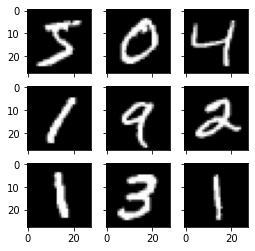

In [1]:
# Plot images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
# load dbata
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# create a grid of 3x3 images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(X_train[i*3+j], cmap=plt.get_cmap("gray"))
# show the plot
plt.show()

-0.42407447 -0.04093817 2.8215446


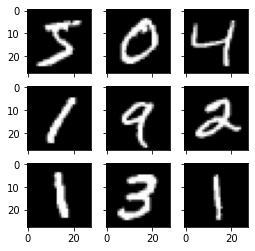

In [2]:
# Standardize images across the dataset, mean=0, stdev=1
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

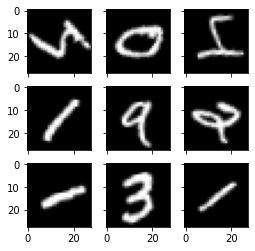

In [4]:
# Random Rotations
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(rotation_range=90)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

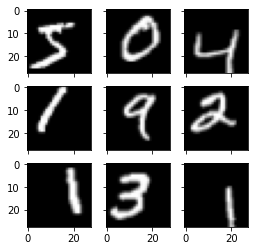

In [5]:

# Random Shifts
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

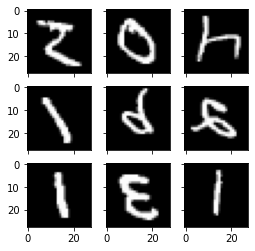

In [6]:
# Random Flips
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

In [ ]:
# Tạo ra augmented generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

# Fit data generator cho tập train
datagen.fit(train)

# Tạo ra batch với generator 
X_batch, y_batch = datagen.flow(train, train, batch_size=32)

#Huấn luyện mô hình với generator
fit_generator(datagen, samples_per_epoch=len(train), epochs=100)

# 1. Convolution

## 1.1 Compute CNN

In [2]:
def conv2d(X, K): 
    """Compute 2D convolution."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 1.2 Su dung 1 kernel nhu la mot edge detector

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = conv2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

## 1.3 Huan luyen kernel

In [9]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 9.717
epoch 4, loss 1.705
epoch 6, loss 0.317
epoch 8, loss 0.066
epoch 10, loss 0.016


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9937, -0.9744]])

Kernel duoc hoc nay tien gan voi kernel K dinh san o tren

# 2. Pooling

## 2.1 Max va average pooling

In [11]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [12]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [13]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## 2.2 Them padding va stride

In [14]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [15]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [16]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

# 3. Multi channels

In [17]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [18]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 4. Cac mo hinh CNN

## 4.1 LeNet

In [19]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [20]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [21]:
# TODO: dung pretrained model on mnist to run inference